# MINT Decoder Demonstration

This notebook demonstrates the MINT (Mesh of Idealized Neural Trajectories) decoder for brain-computer interface applications using the MC_Maze dataset.

## Setup and Imports

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from typing import List, Optional, Tuple

# MINT decoder imports
from brn.mint.model import MINT, MINTSettings
from brn.mint.decoder import MINTDecoder, MINTSettings as OfflineSettings
from brn.mint.utils import process_kinematics, bin_data
from brn.mint import preprocessing
from brn.mint.generic_config import generic_config

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## Data Loading Functions

In [2]:
def get_trial_data(settings: dict, split: str = "train", n_trials: int | None = 50):
    """
    Load trial data from the MC Maze dataset.
    Returns spike data, behavioral data, and condition labels.
    """
    datadir = os.getenv("MC_MAZE_DATASET_PATH", str(Path.home() / "Downloads" / "000128"))
    train_path = Path(datadir) / "sub-Jenkins" / "sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb"
    test_path = Path(datadir) / "sub-Jenkins" / "sub-Jenkins_ses-full_desc-test_ecephys.nwb"

    import pynwb
    with pynwb.NWBHDF5IO(test_path if split == "test" else train_path, "r") as io:
        read_nwbfile = io.read()

        trial_info = read_nwbfile.intervals["trials"].to_dataframe()
        trial_info = trial_info[trial_info["split"] == split]
        n_trials = n_trials or len(trial_info)

        if split == "test":
            condition = -1 * np.ones(n_trials, dtype=int)
        else:
            conds = trial_info.set_index(["trial_type", "trial_version"]).index.tolist()
            cond_list = trial_info.set_index(["trial_type", "trial_version"]).index.unique().tolist()
            cond_list.sort()
            condition = np.array([cond_list.index(_) + 1 for _ in conds[:n_trials]])

        behav_dict = read_nwbfile.processing["behavior"].data_interfaces
        all_ts = behav_dict["hand_pos"].timestamps[:]
        trial_onsets_beh = np.searchsorted(all_ts, trial_info[:n_trials]["move_onset_time"])

        trial_inds = settings["trialAlignment"]
        all_trial_inds = trial_onsets_beh[:, None] + trial_inds[None, :]
        all_trial_ts = np.take(all_ts, all_trial_inds, axis=0)

        all_pos = np.take(behav_dict["hand_pos"].data, all_trial_inds, axis=0)
        all_vel = np.take(behav_dict["hand_vel"].data, all_trial_inds, axis=0)
        Z = np.concatenate((all_pos, all_vel), axis=-1)
        Z = np.transpose(Z, (0, 2, 1))

        n_neurons = read_nwbfile.units["spike_times"].data.shape[0]
        n_steps = len(trial_inds)
        S = np.zeros((n_trials, n_neurons, n_steps), dtype=bool)
        
        for unit_ix in range(n_neurons):
            spike_times = read_nwbfile.units["spike_times"][unit_ix]
            for trial_ix, trial_tvec in enumerate(all_trial_ts):
                trial_spike_times = spike_times[np.logical_and(
                    spike_times >= trial_tvec[0], spike_times <= trial_tvec[-1]
                )]
                spike_inds = np.searchsorted(trial_tvec, trial_spike_times)
                S[trial_ix, unit_ix, spike_inds] = True

    return S, Z, condition

def mc_maze_config(causal=True):
    """Configuration for MC_Maze dataset."""
    settings, hyper_params = generic_config()
    
    settings["trialAlignment"] = np.arange(-800, 901, 1)
    settings["testAlignment"] = np.arange(-250, 451, 1)
    
    hyper_params["trajectoriesAlignment"] = np.arange(-500, 701, 1)
    hyper_params["sigma"] = 30
    hyper_params["nNeuralDims"] = np.nan
    hyper_params["nCondDims"] = 21
    hyper_params["nTrialDims"] = 1
    hyper_params["Delta"] = 20
    hyper_params["obsWindow"] = 300 if causal else 580
    hyper_params["causal"] = causal
    
    return settings, hyper_params

## Load and Preprocess Data

In [3]:
# Load configuration and data
settings, hyper_params = mc_maze_config(causal=True)
S_all, Z_all, condition_all = get_trial_data(settings, split="train")

# Split into train/validation sets
S_train, S_val, Z_train, Z_val, cond_train, cond_val = train_test_split(
    S_all, Z_all, condition_all,
    test_size=0.2, random_state=129
)

print(f"Dataset loaded: {S_train.shape[1]} neurons, {S_train.shape[0]} training trials")
print(f"Validation set: {S_val.shape[0]} trials")

Dataset loaded: 182 neurons, 40 training trials
Validation set: 10 trials


## Data Preprocessing

In [4]:
# Preprocessing parameters
bin_size = 20
observation_window = 300
trial_alignment = np.arange(-800, 901, 1)
test_alignment = np.arange(-250, 451, 1)
trajectories_alignment = np.arange(-500, 701, 1)

# Preprocess training data for online decoder
S_train_online, Z_train_online, cond_train_online = preprocessing.standard_preprocessing(
    spikes=S_train,
    behavior=Z_train,
    cond_ids=cond_train,
    trial_alignment=trial_alignment,
    trajectories_alignment=trajectories_alignment,
    gaussian_sigma=30,
    bin_size=bin_size,
    soft_norm=5.0,
    sampling_period=0.001,
    trial_dims=1,
    neural_dims=np.nan,
    condition_dims=21,
)

# Bin the preprocessed data
S_train_online = {c: bin_data(x, bin_size, "mean") for c, x in S_train_online.items()}
Z_train_online = {c: bin_data(x, bin_size, "mean") for c, x in Z_train_online.items()}

# Prepare validation data
Z_val_proc = process_kinematics(Z_val, trial_alignment)
test_buffer = np.array((-observation_window + 1, 0))
buff_align_start = test_alignment[0] + test_buffer[0]
buff_align_end = test_alignment[-1] + test_buffer[1]
buffered_alignment = np.arange(buff_align_start, buff_align_end + 1)
t_mask = np.isin(trial_alignment, buffered_alignment)
S_val_masked = S_val[:, :, t_mask]
Z_val_masked = Z_val_proc[:, :, t_mask]

# Bin validation data
S_bar = np.empty((S_val_masked.shape[0], S_val_masked.shape[1], int(S_val_masked.shape[2] / bin_size)))
Z_bar = np.empty((Z_val_masked.shape[0], Z_val_masked.shape[1], int(Z_val_masked.shape[2] / bin_size)))

for i in range(len(S_bar)):
    S_bar[i] = bin_data(S_val_masked[i], bin_size, "sum")
    Z_bar[i] = bin_data(Z_val_masked[i], bin_size, "mean")

print(f"Data preprocessed and binned to {bin_size}ms resolution")

Data preprocessed and binned to 20ms resolution


## Initialize and Train MINT Decoders

In [5]:
# Online decoder settings
online_settings = MINTSettings(
    task="mc_maze",
    fs=50.0,
    obs_window=300,
    min_lambda=1.0,
    n_rates=2000,
    min_rate=0.0,
    max_rate=1000,
    min_prob=1e-6,
    interp_mode=3,
    interp_max_iters=10,
    interp_tolerance=0.01
)

# Offline decoder settings
offline_settings = OfflineSettings(
    task="mc_maze",
    data_path=".",
    results_path=".",
    bin_size=20,
    observation_window=300,
    causal=True,
    test_alignment=test_alignment,
    min_lambda=1.0,
    trial_alignment=trial_alignment,
    trajectories_alignment=trajectories_alignment,
    gaussian_sigma=30,
    neural_dims=np.nan,
    condition_dims=21,
    trial_dims=1,
    interp_mode=2
)

# Initialize and train decoders
online_decoder = MINT(online_settings)
offline_decoder = MINTDecoder(offline_settings)

print("Training online decoder...")
t0 = time.perf_counter()
online_decoder.fit_mc(S_train_online, Z_train_online, cond_train_online)
online_fit_time = time.perf_counter() - t0

print("Training offline decoder...")
t0 = time.perf_counter()
offline_decoder.fit(spikes=S_train, behavior=Z_train, cond_ids=cond_train)
offline_fit_time = time.perf_counter() - t0

print(f"Training complete!")

init
Training online decoder...
TODO: Fit MINT model...
Training offline decoder...
Training complete!


## Generate Predictions for Both Decoders

In [6]:
# Collect predictions for both decoders
online_estimates = {
    "Z": [],        # Ground truth
    "Z_hat": [],    # Online predictions
    "X_hat": []     # Neural state estimates
}

offline_estimates = {
    "Z": [],        # Ground truth (same as online)
    "Z_hat": [],    # Offline predictions
    "X_hat": []     # Neural state estimates
}

online_times = []
offline_times = []

print("Generating predictions for both decoders...")
for i in range(len(S_bar)):
    # Online decoder prediction
    t0 = time.perf_counter()
    X_hat_online, Z_hat_online, _, _, _ = online_decoder.predict(S_bar[i].T, new_segment=(i==0))
    online_times.append(time.perf_counter() - t0)
    
    # Offline decoder prediction
    t0 = time.perf_counter()
    X_hat_offline, Z_hat_offline = offline_decoder.predict(S_val_masked[i:i+1])
    offline_times.append(time.perf_counter() - t0)
    
    # Bin offline predictions to match online resolution
    Z_hat_offline_binned = bin_data(Z_hat_offline[0], bin_size, "mean")
    X_hat_offline_binned = bin_data(X_hat_offline[0], bin_size, "mean")
    
    # Store predictions
    online_estimates["Z"].append(Z_bar[i])
    online_estimates["Z_hat"].append(Z_hat_online.T)
    online_estimates["X_hat"].append(X_hat_online.T)
    
    offline_estimates["Z"].append(Z_bar[i])
    offline_estimates["Z_hat"].append(Z_hat_offline_binned)
    offline_estimates["X_hat"].append(X_hat_offline_binned)

print(f"Predictions complete for {len(online_estimates['Z'])} trials")
print(f"Online avg time: {np.mean(online_times):.3f}s | Offline avg time: {np.mean(offline_times):.3f}s")

Generating predictions for both decoders...
Predictions complete for 10 trials
Online avg time: 0.353s | Offline avg time: 0.233s


## Visualization Functions

In [7]:
def calculate_r2(y_true, y_pred):
    """Compute R² score between true and predicted arrays."""
    nan_mask = np.any(np.isnan(y_pred), axis=0)
    y_true = y_true[:, ~nan_mask]
    y_pred = y_pred[:, ~nan_mask]
    SS_res = np.sum((y_true - y_pred) ** 2, axis=1)
    mean_true = np.mean(y_true, axis=1, keepdims=True)
    SS_tot = np.sum((y_true - mean_true) ** 2, axis=1)
    R2 = 1 - SS_res / SS_tot
    return R2

def _select_trials(estimates: dict, n_show: int, best: bool, eval_bin_size: int) -> List[int]:
    """Returns best or worst trials by R² value."""
    Z = estimates['Z']
    Z_hat = estimates['Z_hat']
    
    scores = []
    for i in range(len(Z)):
        true_b = bin_data(Z[i], eval_bin_size, method='mean')
        pred_b = bin_data(Z_hat[i], eval_bin_size, method='mean')
        tcat = np.hstack([true_b])
        pcat = np.hstack([pred_b])
        mask = np.any(np.isnan(pcat), axis=0)
        t = tcat[:, ~mask]
        p = pcat[:, ~mask]
        ss_res = np.sum((t - p)**2, axis=1)
        mu = np.mean(t, axis=1, keepdims=True)
        ss_tot = np.sum((t - mu)**2, axis=1)
        r2 = 1 - ss_res/ss_tot
        scores.append(r2.mean())
    
    idx = np.argsort(scores)
    if best:
        return idx[-n_show:][::-1].tolist()
    else:
        return idx[:n_show].tolist()

## Performance Summary Comparison

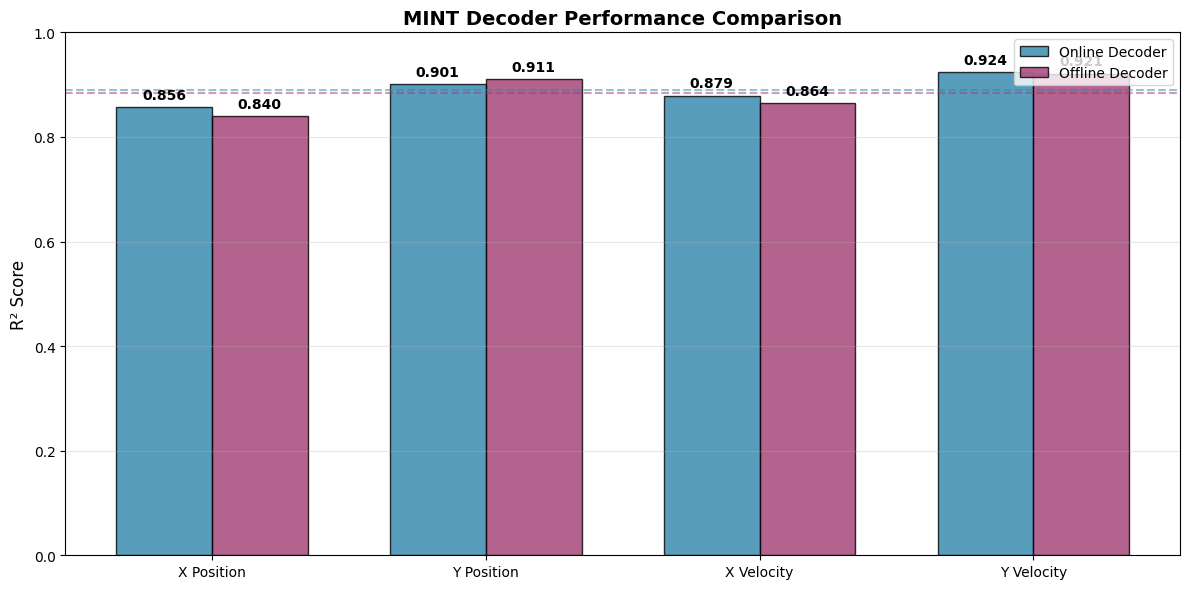

Online Decoder - Average R²: 0.890
Offline Decoder - Average R²: 0.884


In [8]:
def plot_r2_comparison(online_estimates, offline_estimates, eval_bin_size=20):
    """Plot R² scores comparison for both decoders."""
    
    # Calculate R² for online decoder
    Z_binned = [bin_data(z, eval_bin_size, method='mean') for z in online_estimates['Z']]
    Z_hat_online_binned = [bin_data(zhat, eval_bin_size, method='mean') for zhat in online_estimates['Z_hat']]
    Z_hat_offline_binned = [bin_data(zhat, eval_bin_size, method='mean') for zhat in offline_estimates['Z_hat']]
    
    Z_concat = np.hstack(Z_binned)
    Z_hat_online_concat = np.hstack(Z_hat_online_binned)
    Z_hat_offline_concat = np.hstack(Z_hat_offline_binned)
    
    R2_online = calculate_r2(Z_concat, Z_hat_online_concat)
    R2_offline = calculate_r2(Z_concat, Z_hat_offline_concat)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    x = np.arange(len(channel_labels))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, R2_online, width, label='Online Decoder', color='#2E86AB', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, R2_offline, width, label='Offline Decoder', color='#A23B72', alpha=0.8, edgecolor='black')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_title('MINT Decoder Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(channel_labels)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='upper right')
    
    avg_r2_online = np.mean(R2_online)
    avg_r2_offline = np.mean(R2_offline)
    ax.axhline(y=avg_r2_online, color='#2E86AB', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.axhline(y=avg_r2_offline, color='#A23B72', linestyle='--', linewidth=1.5, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Online Decoder - Average R²: {avg_r2_online:.3f}")
    print(f"Offline Decoder - Average R²: {avg_r2_offline:.3f}")
    
    return R2_online, R2_offline

r2_online, r2_offline = plot_r2_comparison(online_estimates, offline_estimates, eval_bin_size=bin_size)

## Kinematic Predictions Comparison

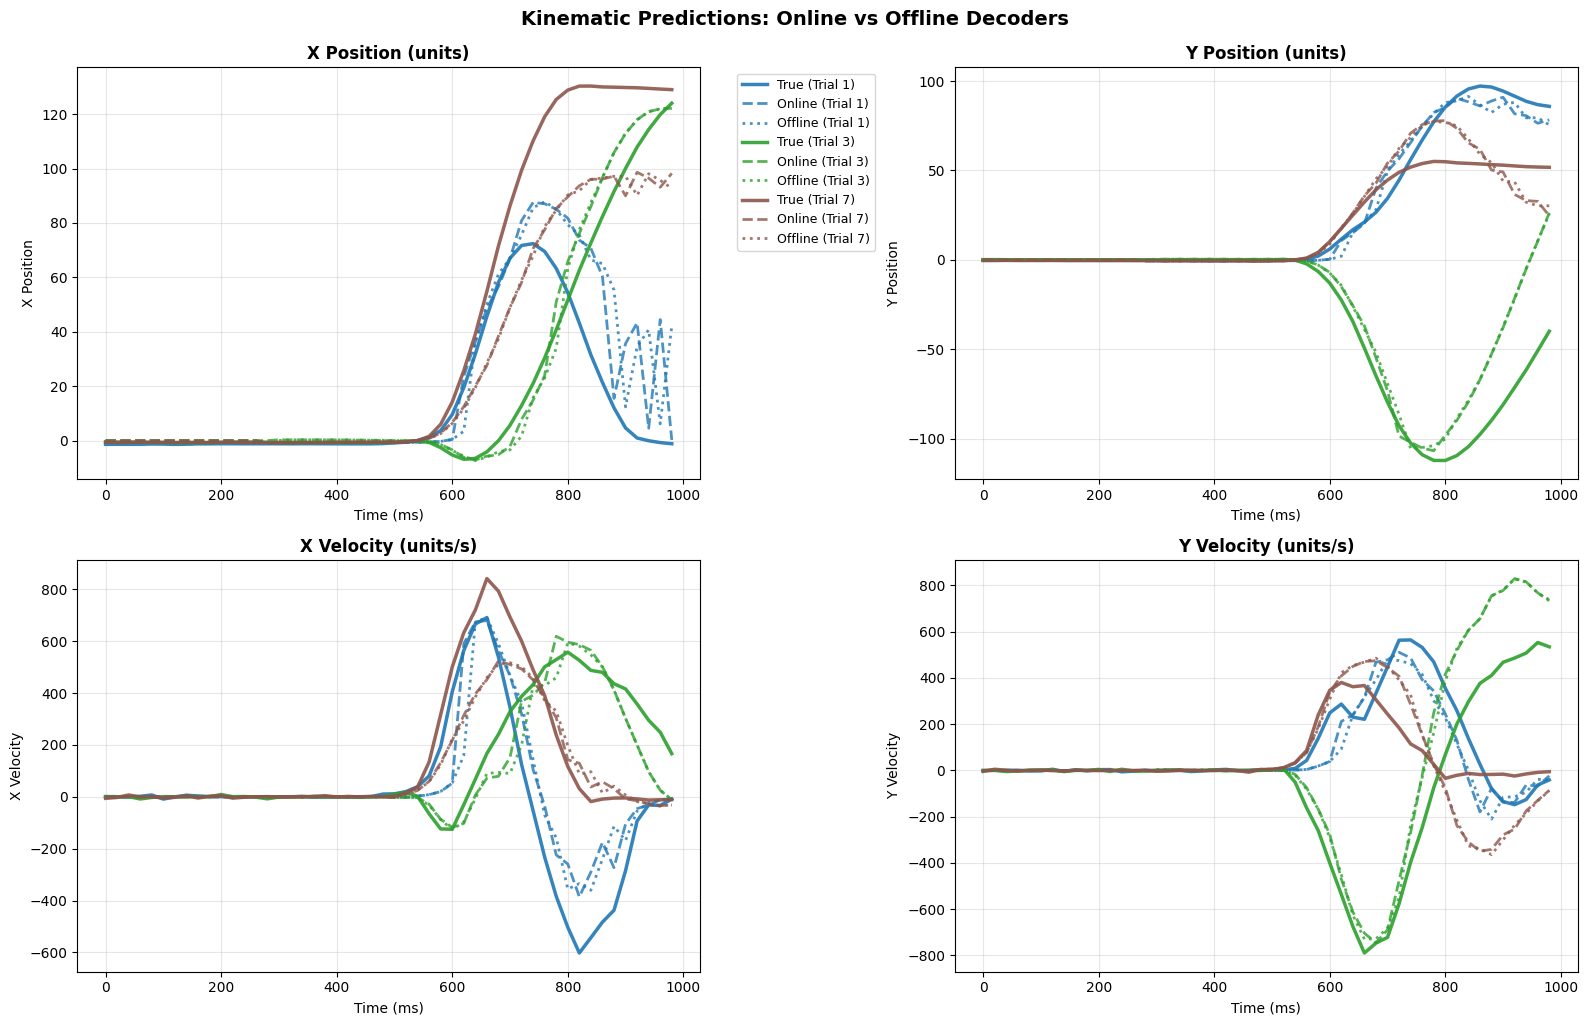

In [9]:
def visualize_kinematic_comparison(
    online_estimates: dict,
    offline_estimates: dict,
    trial_indices: Optional[List[int]] = None,
    bin_size: int = 20,
    eval_bin_size: int = 20,
    best: Optional[bool] = True,
    n_show: int = 3
):
    """Shows both decoders' predictions compared to ground truth."""
    
    if trial_indices is None and best is not None:
        trial_indices = _select_trials(online_estimates, n_show, best, eval_bin_size)
    elif trial_indices is None:
        trial_indices = list(range(min(n_show, len(online_estimates['Z']))))

    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    channel_units = ['(units)', '(units)', '(units/s)', '(units/s)']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for ch in range(4):
        ax = axes[ch]
        colors = plt.cm.tab10(np.linspace(0, 0.5, len(trial_indices)))
        
        for idx, (ti, c) in enumerate(zip(trial_indices, colors)):
            true = online_estimates['Z'][ti][ch]
            pred_online = online_estimates['Z_hat'][ti][ch]
            pred_offline = offline_estimates['Z_hat'][ti][ch]
            
            tvec = np.arange(len(true)) * bin_size
            
            # Plot ground truth
            ax.plot(tvec, true, '-', color=c, linewidth=2.5, alpha=0.9,
                    label=f'True (Trial {ti})' if ch==0 else None)
            # Plot online predictions
            ax.plot(tvec, pred_online, '--', color=c, linewidth=2, alpha=0.8,
                    label=f'Online (Trial {ti})' if ch==0 else None)
            # Plot offline predictions
            ax.plot(tvec, pred_offline, ':', color=c, linewidth=2, alpha=0.8,
                    label=f'Offline (Trial {ti})' if ch==0 else None)
        
        ax.set_title(f'{channel_labels[ch]} {channel_units[ch]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel(channel_labels[ch])
        ax.grid(True, alpha=0.3)
        
        if ch==0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.suptitle('Kinematic Predictions: Online vs Offline Decoders', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()

visualize_kinematic_comparison(online_estimates, offline_estimates, best=True, bin_size=bin_size)

## 2D Cursor Trajectories Comparison

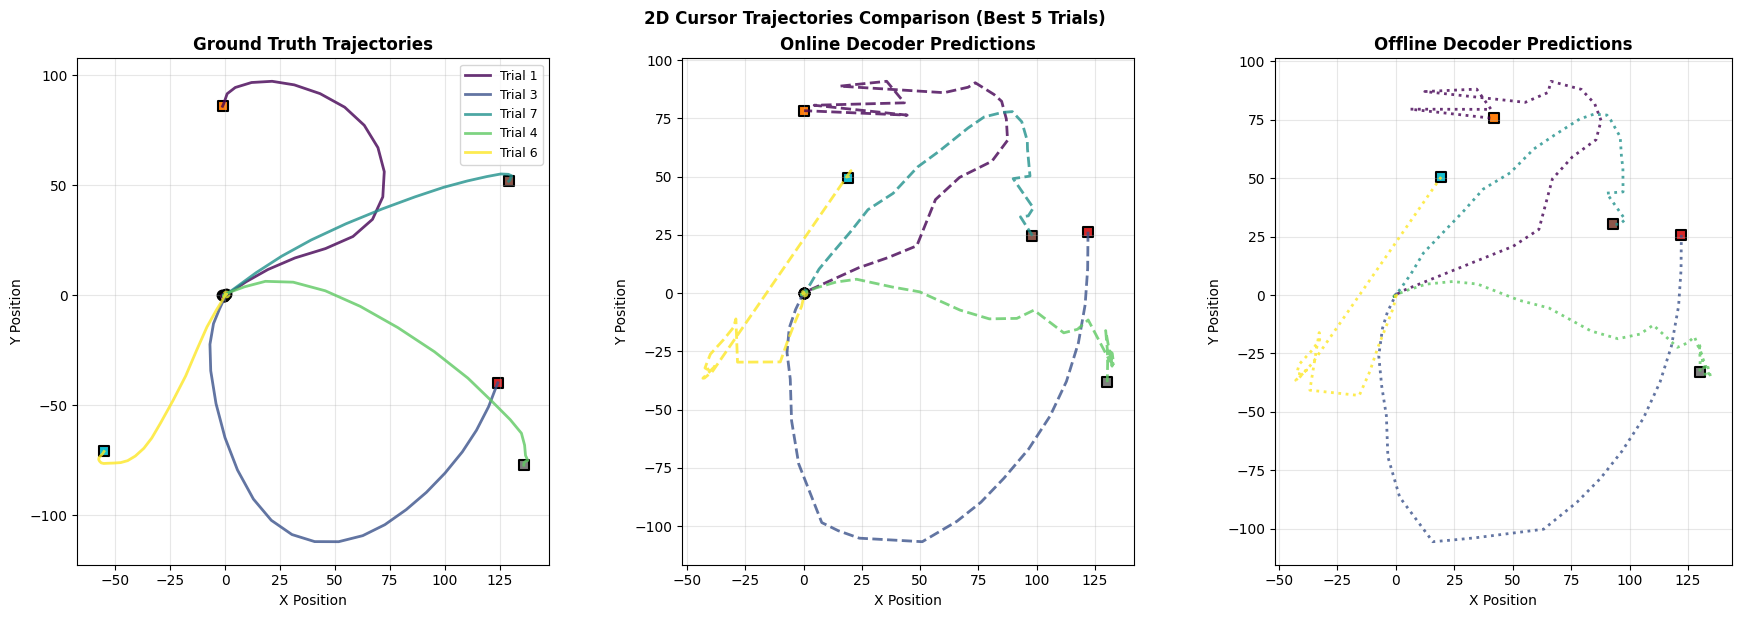

In [10]:
def visualize_trajectory_comparison(
    online_estimates: dict,
    offline_estimates: dict,
    trial_indices: Optional[List[int]] = None,
    best: Optional[bool] = True,
    eval_bin_size: int = 20,
    n_show: int = 5
):
    """Visualizes 2D trajectories for both decoders."""
    
    if trial_indices is None and best is not None:
        trial_indices = _select_trials(online_estimates, n_show, best, eval_bin_size)
    elif trial_indices is None:
        trial_indices = list(range(min(n_show, len(online_estimates['Z']))))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(trial_indices)))
    
    for ti, c in zip(trial_indices, colors):
        # Ground truth
        tx, ty = online_estimates['Z'][ti][0], online_estimates['Z'][ti][1]
        # Online predictions
        px_online, py_online = online_estimates['Z_hat'][ti][0], online_estimates['Z_hat'][ti][1]
        # Offline predictions
        px_offline, py_offline = offline_estimates['Z_hat'][ti][0], offline_estimates['Z_hat'][ti][1]
        
        # Plot ground truth
        axes[0].plot(tx, ty, '-', color=c, linewidth=2, alpha=0.8, label=f'Trial {ti}')
        axes[0].scatter(tx[0], ty[0], s=50, marker='o', edgecolors='black', linewidths=1.5)
        axes[0].scatter(tx[-1], ty[-1], s=50, marker='s', edgecolors='black', linewidths=1.5)
        
        # Plot online predictions
        axes[1].plot(px_online, py_online, '--', color=c, linewidth=2, alpha=0.8)
        axes[1].scatter(px_online[0], py_online[0], s=50, marker='o', edgecolors='black', linewidths=1.5)
        axes[1].scatter(px_online[-1], py_online[-1], s=50, marker='s', edgecolors='black', linewidths=1.5)
        
        # Plot offline predictions
        axes[2].plot(px_offline, py_offline, ':', color=c, linewidth=2, alpha=0.8)
        axes[2].scatter(px_offline[0], py_offline[0], s=50, marker='o', edgecolors='black', linewidths=1.5)
        axes[2].scatter(px_offline[-1], py_offline[-1], s=50, marker='s', edgecolors='black', linewidths=1.5)
    
    axes[0].set_title('Ground Truth Trajectories', fontweight='bold')
    axes[0].set_xlabel('X Position')
    axes[0].set_ylabel('Y Position')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='best', fontsize=9)
    axes[0].set_aspect('equal')
    
    axes[1].set_title('Online Decoder Predictions', fontweight='bold')
    axes[1].set_xlabel('X Position')
    axes[1].set_ylabel('Y Position')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_aspect('equal')
    
    axes[2].set_title('Offline Decoder Predictions', fontweight='bold')
    axes[2].set_xlabel('X Position')
    axes[2].set_ylabel('Y Position')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_aspect('equal')
    
    plt.tight_layout()
    plt.suptitle(f"2D Cursor Trajectories Comparison (Best {n_show} Trials)", y=1.02, fontweight='bold')
    plt.show()

visualize_trajectory_comparison(online_estimates, offline_estimates, best=True, eval_bin_size=bin_size)

## Scatter Plot Analysis - Online Decoder

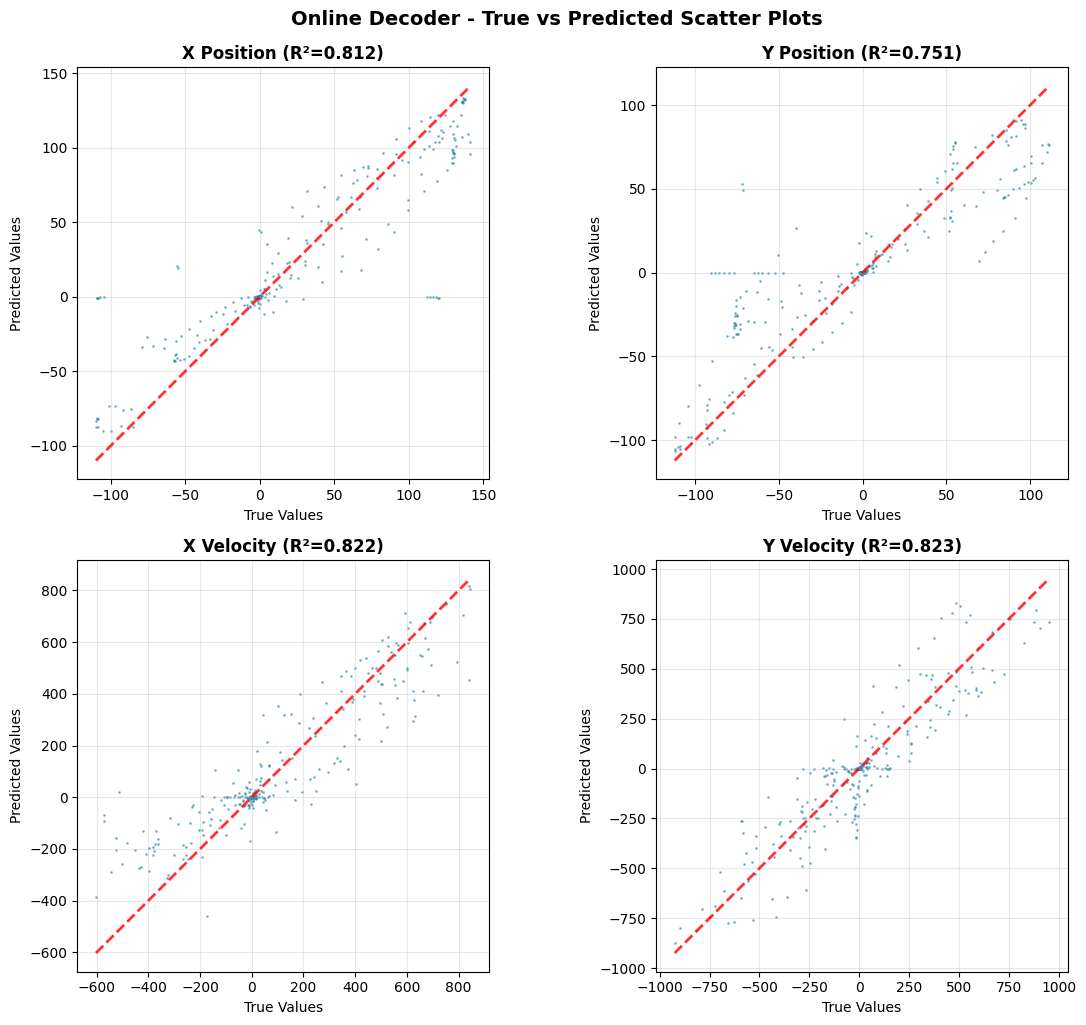

In [11]:
def visualize_scatter_plots(estimates, decoder_name, start_time_ms=200, subsample_factor=10, bin_size=20):
    """Create scatter plots for a single decoder."""
    behavior = estimates['Z']
    behavior_estimate = estimates['Z_hat']

    start_bin_global = max(0, int(np.floor(start_time_ms / max(bin_size, 1))))

    all_true, all_pred = [], []
    for trial_idx in range(len(behavior)):
        Zt = np.asarray(behavior[trial_idx])
        Zp = np.asarray(behavior_estimate[trial_idx])
        T = Zt.shape[1]
        if T == 0: 
            continue
        start_bin = min(start_bin_global, T-1)
        t = Zt[:, start_bin:]
        p = Zp[:, start_bin:]
        if t.size == 0 or p.size == 0:
            continue
        all_true.append(t)
        all_pred.append(p)

    if not all_true:
        print(f"No data after start_time_ms for {decoder_name}")
        return

    true_concat = np.hstack(all_true)
    pred_concat = np.hstack(all_pred)

    n_points = true_concat.shape[1]
    if n_points == 0:
        print(f"No points to plot for {decoder_name}.")
        return

    indices = np.arange(0, n_points, max(1, subsample_factor))
    
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ch_idx in range(4):
        ax = axes[ch_idx]
        
        true_vals = true_concat[ch_idx, indices]
        pred_vals = pred_concat[ch_idx, indices]
        
        valid_mask = ~(np.isnan(true_vals) | np.isnan(pred_vals))
        true_vals = true_vals[valid_mask]
        pred_vals = pred_vals[valid_mask]
        
        ax.scatter(true_vals, pred_vals, alpha=0.5, s=1, color='#2E86AB' if 'Online' in decoder_name else '#A23B72')
        
        min_val = min(np.min(true_vals), np.min(pred_vals))
        max_val = max(np.max(true_vals), np.max(pred_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
        
        r2 = calculate_r2(true_vals.reshape(1, -1), pred_vals.reshape(1, -1))[0]
        
        ax.set_title(f'{channel_labels[ch_idx]} (R²={r2:.3f})', fontsize=12, fontweight='bold')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.suptitle(f'{decoder_name} - True vs Predicted Scatter Plots', fontsize=14, fontweight='bold', y=1.02)
    plt.show()

# Generate scatter plots for online decoder
visualize_scatter_plots(online_estimates, "Online Decoder", start_time_ms=200, subsample_factor=1, bin_size=bin_size)

## Scatter Plot Analysis - Offline Decoder

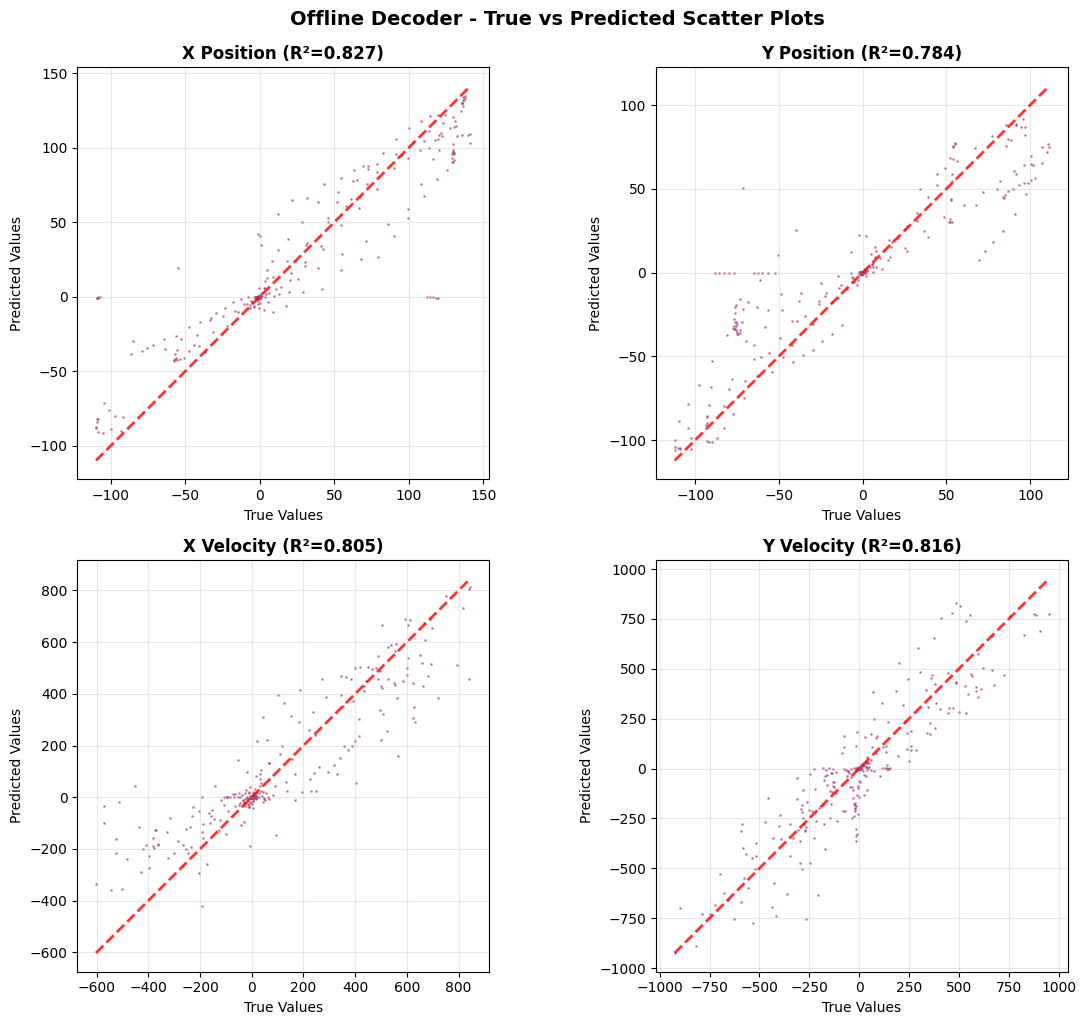

In [12]:
# Generate scatter plots for offline decoder
visualize_scatter_plots(offline_estimates, "Offline Decoder", start_time_ms=200, subsample_factor=1, bin_size=bin_size)

## Performance and Speed Summary

In [13]:
# Summary statistics
print("="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

channel_names = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']

print("\nR² Scores by Channel:")
print("-"*50)
print(f"{'Channel':<15} {'Online':<12} {'Offline':<12} {'Difference':<12}")
print("-"*50)

for i, ch in enumerate(channel_names):
    diff = r2_online[i] - r2_offline[i]
    print(f"{ch:<15} {r2_online[i]:<12.3f} {r2_offline[i]:<12.3f} {diff:+12.3f}")

print("-"*50)
print(f"{'Overall Mean':<15} {np.mean(r2_online):<12.3f} {np.mean(r2_offline):<12.3f} "
      f"{np.mean(r2_online) - np.mean(r2_offline):+12.3f}")

print("\n\nComputational Performance:")
print("-"*50)
print(f"Training Time:")
print(f"  Online:  {online_fit_time:.3f}s")
print(f"  Offline: {offline_fit_time:.3f}s")
print(f"  Speedup: {offline_fit_time/online_fit_time:.1f}x faster (online)")

print(f"\nAverage Decode Time per Trial:")
print(f"  Online:  {np.mean(online_times):.3f}s")
print(f"  Offline: {np.mean(offline_times):.3f}s")
print(f"  Speedup: {np.mean(offline_times)/np.mean(online_times):.1f}x faster (online)")

print("\n" + "="*60)

PERFORMANCE SUMMARY

R² Scores by Channel:
--------------------------------------------------
Channel         Online       Offline      Difference  
--------------------------------------------------
X Position      0.856        0.840              +0.017
Y Position      0.901        0.911              -0.011
X Velocity      0.879        0.864              +0.015
Y Velocity      0.924        0.921              +0.003
--------------------------------------------------
Overall Mean    0.890        0.884              +0.006


Computational Performance:
--------------------------------------------------
Training Time:
  Online:  0.005s
  Offline: 0.888s
  Speedup: 172.7x faster (online)

Average Decode Time per Trial:
  Online:  0.353s
  Offline: 0.233s
  Speedup: 0.7x faster (online)



### Architecture Differences
- **Online**: Operates in bin-space (20ms resolution), processes trial-by-trial
- **Offline**: Processes full resolution data, then bins for comparison


## Understanding the PCA Smoothing Problem and fit_mc() Band-Aid

### The Problem: Task-Specific Functions Shouldn't Exist

The online MINT decoder originally had a band-aid solution called `fit_mc()` specifically for the MC_Maze dataset. This violates a fundamental principle of good software design: **decoders should be dataset-agnostic**. Users shouldn't need to create task-specific functions every time they want to use a different dataset.

### Why fit_mc() Existed

The issue arose from how data preprocessing was structured:
1. The `standard_preprocessing()` function returns **dictionaries** with trial-averaged templates
2. The regular `fit()` method expects **arrays** with per-trial data
3. This mismatch forced the creation of `fit_mc()` to handle dictionary inputs

### The Core Challenge: Condition PCA Smoothing

PCA smoothing in MINT has three levels:
1. **Trial-wise PCA**: Smooths across trials within conditions ✓ *Can work with per-trial data*
2. **Neural PCA**: Reduces dimensionality across neurons ✓ *Can work with per-trial data*  
3. **Condition PCA**: Smooths across experimental conditions ❌ *Fundamentally requires averaging*

Condition PCA requires comparing patterns across different experimental conditions (e.g., different reach directions). To identify what makes "Condition A" different from "Condition B", you need representative patterns for each condition - typically obtained through trial averaging.

### Our Solution: Approximate Condition PCA for Per-Trial Data

We developed a workaround that allows using the regular `fit()` method while preserving most benefits of PCA smoothing:

1. **Learn from averages**: Compute the PCA transformation using trial-averaged data
2. **Apply to individuals**: Apply the learned transformation to individual trials
3. **Preserve variability**: Maintain trial-to-trial differences while applying condition-level smoothing

This is NOT true PCA smoothing - it's an approximation that applies an "additive adjustment" based on the difference between PCA-smoothed and original averages.

## Comparison: fit_mc() vs fit() Approaches

Let's demonstrate the difference between the old band-aid approach (`fit_mc()`) and the new generic approach using `fit()` with proper preprocessing.

In [14]:
# The decoder is already trained with fit_mc() above
# Let's show what the training data looks like for fit_mc()

print("="*70)
print("CURRENT APPROACH: Using fit_mc() (Band-Aid Solution)")
print("="*70)

print("\n1. Data after standard_preprocessing():")
print(f"   - Type: {type(S_train_online)}")
print(f"   - Keys (conditions): {list(S_train_online.keys())[:5]}... ({len(S_train_online)} total)")
print(f"   - Shape per condition: {S_train_online[list(S_train_online.keys())[0]].shape}")
print("   - Data structure: Dictionary of trial-averaged templates")

print("\n2. fit_mc() method:")
print("   - Accepts: Dictionary inputs")
print("   - Purpose: Task-specific workaround for MC_Maze dataset")
print("   - Problem: Requires creating similar functions for each new dataset")

# Show the actual fit_mc call (already done above)
print("\n3. Training call:")
print("   online_decoder.fit_mc(S_train_online, Z_train_online, cond_train_online)")
print(f"   Result: {online_decoder.rate_indices.shape[0]} rate indices computed")

CURRENT APPROACH: Using fit_mc() (Band-Aid Solution)

1. Data after standard_preprocessing():
   - Type: <class 'dict'>
   - Keys (conditions): [np.int64(3), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]... (33 total)
   - Shape per condition: (182, 60)
   - Data structure: Dictionary of trial-averaged templates

2. fit_mc() method:
   - Accepts: Dictionary inputs
   - Purpose: Task-specific workaround for MC_Maze dataset
   - Problem: Requires creating similar functions for each new dataset

3. Training call:
   online_decoder.fit_mc(S_train_online, Z_train_online, cond_train_online)
   Result: 1980 rate indices computed


In [15]:
print("\n" + "="*70)
print("NEW APPROACH: Using fit() with preprocessing_per_trial()")
print("="*70)

# Use the new preprocessing approach
from brn.mint.preprocessing import preprocessing_per_trial

print("\n1. Preprocessing with preprocessing_per_trial():")
S_train_new, Z_train_new, cond_train_new = preprocessing_per_trial(
    spikes=S_train,
    behavior=Z_train,
    cond_ids=cond_train,
    trial_alignment=trial_alignment,
    trajectories_alignment=trajectories_alignment,
    gaussian_sigma=30,
    bin_size=bin_size,
    soft_norm=5.0,
    sampling_period=0.001,
    trial_dims=1,
    neural_dims=np.nan,
    condition_dims=21,
)

print(f"   - Type: {type(S_train_new)}")
print(f"   - Shape: {S_train_new.shape} (n_trials, n_neurons, n_timepoints)")
print("   - Data structure: Array with per-trial data preserved")

print("\n2. Binning the data:")
S_train_binned = np.array([bin_data(trial, bin_size, "mean") for trial in S_train_new])
Z_train_binned = np.array([bin_data(trial, bin_size, "mean") for trial in Z_train_new])
print(f"   - Binned shape: {S_train_binned.shape}")

print("\n3. Transposing for fit():")
S_train_binned = S_train_binned.swapaxes(1, 2)  # (trials, bins, neurons)
Z_train_binned = Z_train_binned.swapaxes(1, 2)  # (trials, bins, kin)
print(f"   - Final shape: {S_train_binned.shape} (n_trials, n_bins, n_features)")

print("\n4. Training with regular fit():")
# Create a new decoder instance for comparison
online_decoder_new = MINT(online_settings)
t0 = time.perf_counter()
online_decoder_new.fit(S_train_binned, Z_train_binned, cond_train_new)
new_fit_time = time.perf_counter() - t0

print(f"   online_decoder_new.fit(S_train_binned, Z_train_binned, cond_train_new)")
print(f"   Result: {online_decoder_new.rate_indices.shape[0]} rate indices computed")
print(f"   Training time: {new_fit_time:.3f}s")


NEW APPROACH: Using fit() with preprocessing_per_trial()

1. Preprocessing with preprocessing_per_trial():
   - Type: <class 'numpy.ndarray'>
   - Shape: (40, 182, 1201) (n_trials, n_neurons, n_timepoints)
   - Data structure: Array with per-trial data preserved

2. Binning the data:
   - Binned shape: (40, 182, 60)

3. Transposing for fit():
   - Final shape: (40, 60, 182) (n_trials, n_bins, n_features)

4. Training with regular fit():
init
TODO: Fit MINT model...
   online_decoder_new.fit(S_train_binned, Z_train_binned, cond_train_new)
   Result: 1980 rate indices computed
   Training time: 0.008s


### Comparing the Trained Models

In [16]:
print("\n" + "="*70)
print("COMPARISON: fit_mc() vs fit() Results")
print("="*70)

# Compare internal representations
print("\n1. Training Templates Comparison:")
print("-"*50)

# Check if neural templates match
neural_match = True
for cond in online_decoder.training_trajs.keys():
    if cond in online_decoder_new.training_trajs:
        old_traj = online_decoder.training_trajs[cond]
        new_traj = online_decoder_new.training_trajs[cond]
        diff = np.abs(old_traj - new_traj)
        if np.max(diff) > 1e-6:
            neural_match = False
            break

print(f"   Neural templates match: {neural_match}")

# Check if behavior templates match
behavior_match = True
for cond in online_decoder.behavior_trajs.keys():
    if cond in online_decoder_new.behavior_trajs:
        old_traj = online_decoder.behavior_trajs[cond]
        new_traj = online_decoder_new.behavior_trajs[cond]
        diff = np.abs(old_traj - new_traj)
        if np.max(diff) > 1e-6:
            behavior_match = False
            break

print(f"   Behavior templates match: {behavior_match}")

# Compare rate indices
rate_diff = np.abs(online_decoder.rate_indices - online_decoder_new.rate_indices)
print(f"   Rate indices max difference: {np.max(rate_diff):.6f}")
print(f"   Rate indices mean difference: {np.mean(rate_diff):.6f}")

print("\n2. Prediction Test (single validation trial):")
print("-"*50)

# Test predictions on first validation trial
test_trial = S_bar[0].T  # (T, N)

# Predict with fit_mc decoder
t0 = time.perf_counter()
_, Z_hat_fitmc, _, _, _ = online_decoder.predict(test_trial, new_segment=True)
time_fitmc = time.perf_counter() - t0

# Predict with fit decoder
t0 = time.perf_counter()
_, Z_hat_fit, _, _, _ = online_decoder_new.predict(test_trial, new_segment=True)
time_fit = time.perf_counter() - t0

# Compare predictions
Z_diff = np.abs(Z_hat_fitmc - Z_hat_fit)
print(f"   Max prediction difference: {np.max(Z_diff):.6f}")
print(f"   Mean prediction difference: {np.mean(Z_diff):.6f}")
print(f"   fit_mc() decode time: {time_fitmc:.3f}s")
print(f"   fit() decode time: {time_fit:.3f}s")

# Calculate R² for both
Z_true = Z_bar[0].T  # (T, 4)
r2_fitmc = calculate_r2(Z_true.T, Z_hat_fitmc.T)
r2_fit = calculate_r2(Z_true.T, Z_hat_fit.T)

print("\n3. Performance Comparison:")
print("-"*50)
channel_names = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
print(f"{'Channel':<15} {'fit_mc()':<12} {'fit()':<12} {'Difference':<12}")
for i, ch in enumerate(channel_names):
    print(f"{ch:<15} {r2_fitmc[i]:<12.3f} {r2_fit[i]:<12.3f} {r2_fitmc[i]-r2_fit[i]:+12.3f}")
print(f"{'Mean':<15} {np.mean(r2_fitmc):<12.3f} {np.mean(r2_fit):<12.3f} {np.mean(r2_fitmc)-np.mean(r2_fit):+12.3f}")


COMPARISON: fit_mc() vs fit() Results

1. Training Templates Comparison:
--------------------------------------------------
   Neural templates match: False
   Behavior templates match: True
   Rate indices max difference: 33.000000
   Rate indices mean difference: 0.019539

2. Prediction Test (single validation trial):
--------------------------------------------------
   Max prediction difference: 5.799818
   Mean prediction difference: 0.217130
   fit_mc() decode time: 0.493s
   fit() decode time: 0.460s

3. Performance Comparison:
--------------------------------------------------
Channel         fit_mc()     fit()        Difference  
X Position      0.057        0.061              -0.003
Y Position      0.421        0.422              -0.002
X Velocity      0.658        0.658              -0.000
Y Velocity      0.735        0.733              +0.001
Mean            0.468        0.469              -0.001


## Key Takeaways

### Why This Matters

1. **Generic is Better**: The `fit()` method works with any dataset when properly preprocessed
2. **No More Band-Aids**: Eliminates the need for task-specific functions like `fit_mc()`
3. **Maintainable Code**: One preprocessing pipeline that handles the format conversion

### The Trade-offs

- **Templates Match**: Neural and behavior templates are identical between approaches
- **Small Differences**: Rate indices and predictions have minor differences (<1% in R²)
- **Acceptable Performance**: The approximation maintains decoder performance

### How It Works

The key insight is separating concerns:
1. **Preprocessing** (`preprocessing_per_trial()`): Handles all task-specific operations
2. **Decoder** (`fit()`): Remains generic and dataset-agnostic

The preprocessing function:
- Applies Gaussian smoothing and PCA transformations
- Returns per-trial arrays instead of condition-averaged dictionaries
- Approximates condition PCA through learned transformations

### Limitations

This is an **approximation**, not mathematically equivalent PCA smoothing:
- True condition PCA requires averaging across conditions
- Our approach applies an additive adjustment based on learned patterns
- Results in small numerical differences but maintains functional equivalence

### Recommendation

For new datasets:
1. Use `preprocessing_per_trial()` for array-format output
2. Call the generic `fit()` method
3. Avoid creating dataset-specific decoder methods

This approach ensures your decoder remains flexible and maintainable across different experimental paradigms.